<a href="https://colab.research.google.com/github/NganTran-0017/HIDS/blob/main/DL_Models_HIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title Specify parameters before running


SZ =  1#@param {type:"number"}         # Indicate a fraction number to sample train set when it's too big. Located in Data Partition

SEQ_WINDOW =  25#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

BATCH_SZ =  32#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

EPOCHS =  2#@param {type:"integer"} # Indicate the window length to parse the sequence into. Used in Data Parsing section

# Indicate to clean data or not. Used in Data Cleaning section
CLEAN = False #@param {type:"boolean"}
DATA = "MIT-Lpr" #@param {type:"string"}



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

%matplotlib inline

import nltk
nltk.download("popular")

## Tokenizing syscall sequences into n-grams of 6

from nltk.tokenize import word_tokenize
from nltk import ngrams

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

## **Load pre-processed data**

In [6]:
from google.colab import files
files.upload()

{}

In [7]:
# Read in data
x_train = pd.read_csv('train.csv', header = 0)
test_clean = pd.read_csv('test_clean.csv', header = 0)
test_unclean = pd.read_csv('test_unclean.csv', header = 0)


In [8]:

# Separate data and label
y_train = x_train['Label']
x_train.drop(columns='Label', inplace=True)

y_test_clean = test_clean['Label']
test_clean.drop(columns = 'Label', inplace=True)

y_test_unclean = test_unclean['Label']
test_unclean.drop(columns ='Label', inplace=True)

In [9]:
test_unclean

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,51,4,33,38,5,3,6,5,57,8,57,120,3,4,3,4,3,4,3,4,3,4,3,4,3
1,51,4,33,38,5,3,6,5,57,8,57,120,3,4,3,4,3,4,3,4,3,4,3,4,3
2,156,106,105,105,107,106,105,105,107,106,105,105,107,106,105,105,107,6,6,6,1,-1,-1,-1,-1
3,113,20,94,20,101,101,101,101,51,89,101,144,129,86,90,122,113,6,38,5,128,3,19,4,6
4,4,4,57,8,57,120,3,4,3,4,3,6,4,4,4,4,6,5,3,19,4,6,9,10,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,155,4,50,27,2,19,4,127,66,5,93,100,5,112,19,93,19,100,100,100,100,50,88,100,143
135,57,120,3,4,3,4,3,6,4,4,4,6,33,38,5,3,6,5,57,8,57,120,3,4,3
136,60,0,0,5,3,3,3,3,3,3,3,3,3,6,51,51,51,24,156,106,105,105,107,106,105
137,90,122,113,6,38,5,128,3,19,4,6,57,8,57,120,120,4,4,33,51,4,106,105,105,107


 ## **Data Cleaning**
 Remove rows that exist in both normal and intrusion df

In [10]:
## Get % of duplicates in both datasets

# Convert normal df to set, and intrusion df to set
def clean_data(normal, intrusion):
  normal_list = normal.values.tolist()
  intrusion_list = intrusion.values.tolist()
  normal_set = set(tuple(i) for i in normal_list)
  intrusion_set = set(tuple(i) for i in intrusion_list)
  print('List sz vs. Set sz of normal sequences: %d vs. %d'% (len(normal_list),len(normal_set)) )
  print('List sz vs. Set sz of intrusion sequences: %d vs. %d'% (len(intrusion_list),len(intrusion_set)) )
    
  normal_dupplication = (len(normal_list) - len(normal_set)) /len(normal_list)*100 
  intrusion_duplication = (len(intrusion_list)-len(intrusion_set))/len(intrusion_list) * 100

  print('Duplication Rate in Normal Class: %.3f%%'% normal_dupplication )
  print('Duplication Rate in Intrusion Class: %.3f%%'% intrusion_duplication) 
 
  c_intrusion = intrusion_set - normal_set 
  overlap_rate =  len(normal_set.intersection(intrusion_set)) / len(normal_set.union(intrusion_set)) * 100
  print('Overlap rate: %.3f%%' % overlap_rate)
  
  #c_normal = normal_set - intrusion_set
  if len(c_intrusion) == 0:
    print(DATA+' No Duplication!')
  if len(c_intrusion) > 0:
    intrusion = pd.DataFrame(c_intrusion)
  else:
    intrusion = pd.DataFrame(intrusion_set)
  #if len(c_normal) > 0:
  #  normal = pd.DataFrame(c_normal)
  #else:
  normal = pd.DataFrame(normal_set)

  print('After cleaning: \nNormal sz:', len(normal), ' Intrusion sz:', len(c_intrusion) )
  return normal, intrusion

In [11]:
# If the CLEAN parameter at the top is checked, we'll train the model with clean data
if CLEAN:
  filt = y_train == 0
  train_normal = x_train.loc[filt]
  train_intrusion = x_train.loc[~filt]
  normal, intrusion = clean_data(train_normal, train_intrusion) # clean normal and intrusion in Train 

  normal['Label'] = 0; intrusion['Label'] = 1
  x_train = normal.append(intrusion, ignore_index = True)
  x_train = x_train.sample(frac = 1)
  y_train = x_train['Label']
  x_train.drop(columns = 'Label', inplace = True)


# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale






In [12]:
# This function calculate False Positive Rate given a confusion matrix
def calc_false_positive (cmatrix):
  specificity = cmatrix[0,0]/(cmatrix[0,0] + cmatrix[0,1])
  return 1-specificity

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels):
  # rows are actual, columns are predicted
  cmatrix = confusion_matrix(true_labels, pred_labels)
  fpr = calc_false_positive(cmatrix)

  print('Confusion Matrix: \n',cmatrix)
  print('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  print('Precision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  print('Recall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  print('False Positive Rate: %.2f'% fpr)
  print('\nClassification report:', classification_report(true_labels, pred_labels), sep='\n')
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))

  false_positive_rate, recall, thresholds = roc_curve(true_labels, pred_labels)
  roc_auc = auc(false_positive_rate, recall)
  plt.figure()
  if CLEAN: clean_status='Clean '
  else: clean_status ='Overlapped and Duplicated '
  plt.title( model_name+' ROC Curve on '+ clean_status + DATA + ' with Seq Len of '+ str(SEQ_WINDOW))
  plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.2f' %roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], 'r--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.1])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  #plt.savefig(model_name+'-ROC.jpg')
  plt.show()

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix( model_name, model, x_test, y_test, y_predicted):
  class_names = ['Normal', 'Intrusion']

  fig, ax = plt.subplots(figsize=(6, 6))
  plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, 
                        values_format='d', ax = ax, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of ' + str(model_name))
  #plt.savefig(model_name+'-CM.jpg')
  plt.show()

  cmatrix = confusion_matrix(y_test, y_predicted)
  print(cmatrix)

In [13]:
# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC ():
  # Set color for each model
  colors = {'KM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'NN': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'KM':'1--','LR': 'v--', 'SVM': '^--', 'NN': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))
  try:
    plt.plot(KM_test.get('fpr'), KM_test.get('tpr'), markers.get('KM'), color=colors.get('KM'),  label="KM - AUC=" + str(KM_test.get('auc').round(3)))
    plt.plot(LR_test.get('fpr'), LR_test.get('tpr'), markers.get('LR'), color=colors.get('LR'),  label="LR - AUC=" + str(LR_test.get('auc').round(3)))
    plt.plot(SVM_test.get('fpr'),SVM_test.get('tpr'),markers.get('SVM'),color=colors.get('SVM'), label="SVM - AUC="+ str(SVM_test.get('auc').round(3)))
    plt.plot(NN_test.get('fpr'), NN_test.get('tpr'), markers.get('NN'), color=colors.get('NN'),  label="NN - AUC=" + str(NN_test.get('auc').round(3)))
    plt.plot(DT_test.get('fpr'), DT_test.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str(DT_test.get('auc').round(3)))
    plt.plot(RF_test.get('fpr'), RF_test.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str(RF_test.get('auc').round(3)))
    plt.plot(KNN_test.get('fpr'),KNN_test.get('tpr'),markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str(KNN_test.get('auc').round(3)))
    plt.plot(NB_test.get('fpr'), NB_test.get('tpr'), markers.get('NB'), color=colors.get('NB'),  label="NB - AUC=" + str(NB_test.get('auc').round(3)))
  except:
    print('only performances of BERT and GPT are available')

  plt.plot(BERT_test.get('fpr'),BERT_test.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),  label="BERT - AUC="+ str(BERT_test.get('auc').round(3)))
  plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs on ' + DATA)
  #plt.savefig(DATA_I+'-'+train_or_test+'.jpg', dpi = 80)
  plt.show()

# **BERT**


In [14]:
!pip install pytorch_pretrained_bert pytorch-nlp

In [15]:
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

**Prepare for Train and test data for BERT**

In [16]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 

clean_test_texts = []
for i in range(test_clean.shape[0]):
    clean_test_texts.append(" ".join(np.array(test_clean.iloc[i,:]).astype(str)))
clean_test_texts = tuple(clean_test_texts) 

unclean_test_texts = []
for i in range(test_unclean.shape[0]):
     unclean_test_texts.append(" ".join(np.array(test_unclean.iloc[i,:]).astype(str)))
unclean_test_texts = tuple(unclean_test_texts) 


train_labels        = tuple(y_train.tolist())
clean_test_labels   = tuple(y_test_clean.tolist())
unclean_test_labels = tuple(y_test_unclean.tolist())

len(train_texts), len(train_labels), len(clean_test_texts), len(clean_test_labels), len(unclean_test_texts), len(unclean_test_labels)

(237655, 237655, 124, 124, 139, 139)

In [17]:
# Tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Example
tokenizer.tokenize(train_texts[8])

100%|██████████| 231508/231508 [00:00<00:00, 924717.12B/s]


['112',
 '19',
 '93',
 '19',
 '100',
 '50',
 '88',
 '100',
 '143',
 '128',
 '85',
 '89',
 '121',
 '112',
 '5',
 '17',
 '4',
 '127',
 '2',
 '18',
 '3',
 '5',
 '56',
 '7',
 '56']

In [18]:
# Prepare labels
# True if intrusion or False if normal
# Prepare labels
# True if intrusion or False if normal
train_y = np.array(train_labels) == 1
test_clean_y = np.array(clean_test_labels) == 1
test_unclean_y = np.array(unclean_test_labels) == 1

train_y.shape, test_clean_y.shape, test_unclean_y.shape, np.mean(train_y), np.mean(test_clean_y)

((237655,), (124,), (139,), 0.48718520544486754, 0.25)

In [19]:
# Convert to tokens using tokenizer
train_tokens        = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:SEQ_WINDOW] + ['[SEP]'], train_texts))
clean_test_tokens   = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:SEQ_WINDOW] + ['[SEP]'], clean_test_texts))
unclean_test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:SEQ_WINDOW] + ['[SEP]'], unclean_test_texts))

print('Number of Training Sequences:',len(train_tokens), '\nNumber of Clean Testing Sequences:', len(clean_test_tokens), '\nNumber of Unclean Testing Sequences:', len(unclean_test_tokens) )       

Number of Training Sequences: 237655 
Number of Clean Testing Sequences: 124 
Number of Unclean Testing Sequences: 139


In [20]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)
train_tokens_ids         = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen= SEQ_WINDOW, truncating="post", padding="post", dtype="int")
clean_test_tokens_ids    = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, clean_test_tokens)),  maxlen= SEQ_WINDOW, truncating="post", padding="post", dtype="int")
unclean_test_tokens_ids  = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, unclean_test_tokens)),  maxlen= SEQ_WINDOW, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, clean_test_tokens_ids.shape, unclean_test_tokens_ids.shape

((237655, 25), (124, 25), (139, 25))

In [21]:
# To mask the paddings
train_masks        = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
clean_test_masks   = [[float(i > 0) for i in ii] for ii in clean_test_tokens_ids]
unclean_test_masks = [[float(i > 0) for i in ii] for ii in unclean_test_tokens_ids]

In [22]:
# Define BERT model
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        # First Layer
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)

        dropout_output = self.dropout(pooled_output)

        linear_output = self.linear(dropout_output)
        
        # output layer
        proba = self.sigmoid(linear_output)
        
        return proba
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).float()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      param_optimizer = list(self.sigmoid.named_parameters()) 
      optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.bert.parameters(), lr=2e-5)
      for epoch_num in range(epochs):
          self.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

              # Get the output of the model for provided input
              logits = self(token_ids, masks)
              
              # Loss function
              loss_func = nn.BCELoss()

              # Calculate Loss
              batch_loss = loss_func(logits, labels)
              train_loss += batch_loss.item()
              
              # backpropagate the error
              self.zero_grad()
              batch_loss.backward()
              
              # Update the Weights of the Model
              clip_grad_norm_(parameters=self.parameters(), max_norm=1.0)
              optimizer.step()
              
              clear_output(wait=True)
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))        

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

100%|██████████| 407873900/407873900 [00:10<00:00, 37493136.22B/s]


**Fine Tune BERT**

In [25]:
# Train BERT NLP
bert_clf.train_m(train_tokens_ids,train_y,train_masks, EPOCHS, BATCH_SZ)

Epoch:  2
7426/7426.71875 loss: 2.8162526060818986e-06 


**Evaluate on Testing Set**

In [26]:
# Convert token ids to tensor 
clean_test_tokens_tensor = torch.tensor(clean_test_tokens_ids)
unclean_test_tokens_tensor = torch.tensor(unclean_test_tokens_ids)

# Convert labels to tensors
clean_test_y_tensor = torch.tensor(test_clean_y.reshape(-1, 1)).float()
unclean_test_y_tensor = torch.tensor(test_unclean_y.reshape(-1, 1)).float()

# Convert to tensro for maks
clean_test_masks_tensor   = torch.tensor(clean_test_masks)
unclean_test_masks_tensor = torch.tensor(unclean_test_masks)

# Load Token, token mask and label into Dataloader
clean_test_dataset   = TensorDataset(clean_test_tokens_tensor, clean_test_masks_tensor, clean_test_y_tensor)
unclean_test_dataset = TensorDataset(unclean_test_tokens_tensor, unclean_test_masks_tensor, unclean_test_y_tensor)

# Define sampler
clean_test_sampler = SequentialSampler(clean_test_dataset)
unclean_test_sampler = SequentialSampler(unclean_test_dataset)

# Defile test data loader
clean_test_dataloader   = DataLoader(clean_test_dataset,   sampler = clean_test_sampler,   batch_size=128)
unclean_test_dataloader = DataLoader(unclean_test_dataset, sampler = unclean_test_sampler, batch_size=128)


In [27]:
def evaluate_Bert(dataloader):
  bert_clf.eval() # Define eval
  bert_predicted = [] # To Store predicted result
  all_logits = [] # Actual output that is between 0 to 1 is stored here
  with torch.no_grad():
      for step_num, batch_data in enumerate(dataloader):

          # Load the batch on gpu memory
          token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

          # Calculate ouput of bert
          logits = bert_clf(token_ids, masks)

          # Get the numpy logits
          numpy_logits = logits.cpu().detach().numpy()  # Detach from the GPU memory
          
          # Using the threshold find binary 
          bert_predicted += list(numpy_logits[:, 0] > 0.5)  # Threshold conversion
          all_logits += list(numpy_logits[:, 0])
  return bert_predicted

def get_Bert_performance(dataloader, label):
  bert_predicted = evaluate_Bert(dataloader)
  print_performance('BERT', label, bert_predicted)

  # Recording TPR and FPR for the TESTING-ROC curves
  performance = {}
  performance['fpr'], performance['tpr'], thresh = roc_curve(label, bert_predicted)
  performance['auc'] = roc_auc_score(label, bert_predicted)
  return performance



----------------------------Evaluating BERT with Clean Data----------------------------
Confusion Matrix: 
 [[93  0]
 [ 0 31]]

Testing Accuracy: 1.00
Precision:1.00
Recall: 1.00
False Positive Rate: 0.00

Classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        93
        True       1.00      1.00      1.00        31

    accuracy                           1.00       124
   macro avg       1.00      1.00      1.00       124
weighted avg       1.00      1.00      1.00       124

AUC: 1.00


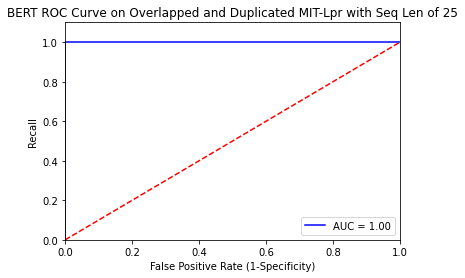

In [28]:
print('----------------------------Evaluating BERT with Clean Data----------------------------')
BERT_clean_perf = get_Bert_performance(clean_test_dataloader, test_clean_y)

----------------------------Evaluating BERT with Unclean Data----------------------------
Confusion Matrix: 
 [[119   0]
 [  0  20]]

Testing Accuracy: 1.00
Precision:1.00
Recall: 1.00
False Positive Rate: 0.00

Classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       119
        True       1.00      1.00      1.00        20

    accuracy                           1.00       139
   macro avg       1.00      1.00      1.00       139
weighted avg       1.00      1.00      1.00       139

AUC: 1.00


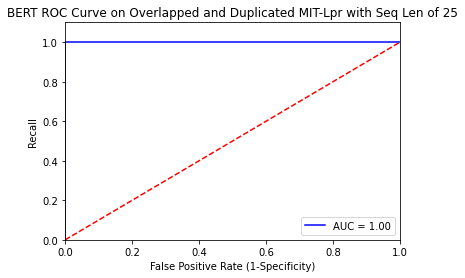

In [29]:
print('----------------------------Evaluating BERT with Unclean Data----------------------------')
BERT_unclean_perf = get_Bert_performance(unclean_test_dataloader, test_unclean_y)

# **GPT-2**

In [30]:
!pip install transformers

from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

In [31]:
tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialoGPT-small')

In [32]:
# Padding sequences from the right to a max length of 20
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
train_tokens        = tokenizer(train_texts,      return_tensors='pt',  truncation=True,  padding=True,  max_length = SEQ_WINDOW)
clean_test_tokens   = tokenizer(clean_test_texts, return_tensors='pt',  truncation=True,  padding=True,  max_length = SEQ_WINDOW)
unclean_test_tokens = tokenizer(unclean_test_texts,return_tensors='pt', truncation=True,  padding=True,  max_length = SEQ_WINDOW)


In [33]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)

train_tokens_ids        = train_tokens.input_ids
clean_test_tokens_ids   = clean_test_tokens.input_ids
unclean_test_tokens_ids = unclean_test_tokens.input_ids

train_tokens_ids.shape, clean_test_tokens_ids.shape, unclean_test_tokens_ids.shape

(torch.Size([237655, 25]), torch.Size([124, 25]), torch.Size([139, 25]))

In [34]:
train_masks        = train_tokens.attention_mask
clean_test_masks   = clean_test_tokens.attention_mask
unclean_test_masks = unclean_test_tokens.attention_mask

**Create GPT-2 Classifer**

In [35]:
class GTP2BinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(GTP2BinaryClassifier, self).__init__()
        self.gtp2 = GPT2ForSequenceClassification.from_pretrained('microsoft/DialoGPT-small')
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).long()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      # param_optimizer = list(self.gtp2.parameters()) 
      # optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.gtp2.parameters(), lr=5e-5)
      for epoch_num in range(epochs):
          self.gtp2.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
              self.zero_grad()

              # Get the output of the model for provided input
              outputs = self.gtp2(token_ids,attention_mask=masks,labels=labels)
              loss, logits = outputs[:2]
              # logits = self(token_ids, masks)
              
              # Total Loss
              train_loss += loss.item()
              
              # Backward pass the loss
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.gtp2.parameters(), 1.0)
              
              optimizer.step()
              logits = logits.detach().cpu().numpy()

              clear_output(wait=True)
        
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))
        

In [36]:
gtp_clf = GTP2BinaryClassifier()
gtp_clf = gtp_clf.cuda()

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/DialoGPT-small were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Configure the Padding token id
gtp_clf.gtp2.config.pad_token_id = tokenizer.eos_token_id
gtp_clf.train_m(train_tokens_ids,train_y,train_masks, EPOCHS, BATCH_SZ)

Epoch:  1
1657/7426.71875 loss: 0.014272211918768327 


**Evaluate on Testing Set**

In [ ]:
clean_test_tokens_tensor = torch.tensor(clean_test_tokens_ids)
unclean_test_tokens_tensor = torch.tensor(unclean_test_tokens_ids)
clean_test_y_tensor   = torch.tensor(test_clean_y.reshape(-1, 1)).long()
unclean_test_y_tensor = torch.tensor(test_unclean_y.reshape(-1, 1)).long()

clean_test_masks_tensor   = torch.tensor(clean_test_masks)
unclean_test_masks_tensor = torch.tensor(unclean_test_masks)


clean_test_dataset   = TensorDataset(clean_test_tokens_tensor, clean_test_masks_tensor, clean_test_y_tensor)
unclean_test_dataset = TensorDataset(unclean_test_tokens_tensor, unclean_test_masks_tensor, unclean_test_y_tensor)

clean_test_sampler = SequentialSampler(clean_test_dataset)
unclean_test_sampler = SequentialSampler(unclean_test_dataset)

clean_test_dataloader = DataLoader(clean_test_dataset,     sampler= clean_test_sampler,   batch_size=128)
unclean_test_dataloader = DataLoader(unclean_test_dataset, sampler= unclean_test_sampler, batch_size=128)


In [ ]:
# Evaluate Model
def evaluate_GPT(dataloader):
  gtp_clf.eval() # Define eval
  gpt_predicted = [] # Store Result
  with torch.no_grad():
      for step_num, batch_data in enumerate(dataloader):

          token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

          # ----------------------------------------------------------------
          outputs = gtp_clf.gtp2(token_ids,attention_mask=masks,labels=labels)
          loss, logits = outputs[:2]
          numpy_logits = logits.detach().cpu().numpy()
          # ----------------------------------------------------------------
          gpt_predicted +=list(numpy_logits.argmax(axis=-1).flatten().tolist())
  return gpt_predicted


def get_GPT_performance(dataloader, label):
  gpt_predicted = evaluate_GPT(dataloader)
  print_performance('GPT', label, gpt_predicted)

  # Recording TPR and FPR for the TESTING-ROC curves
  performance = {}
  performance['fpr'], performance['tpr'], thresh = roc_curve(label, gpt_predicted)
  performance['auc'] = roc_auc_score(label, gpt_predicted)
  return performance

In [ ]:
print('----------------------------Evaluating GPT with Clean Data----------------------------')
GPT_clean_perf = get_GPT_performance(clean_test_dataloader, test_clean_y)

In [ ]:
print('----------------------------Evaluating GPT with Unclean Data----------------------------')
GPT_unclean_perf = get_GPT_performance(unclean_test_dataloader, test_unclean_y)

In [ ]:
# Ploting the overlaid ROC curves on testing results:
#graph_multi_ROC()


def plot_ROC_Clean_Unclean(clean, unclean, model_name):
  colors = {'unclean': 'lightcoral','clean': 'blue'}

  plt.plot(clean.get('fpr'), clean.get('tpr'), color=colors.get('clean'),  label= "AUC on Clean Data =" + str( round(clean.get('auc'), 3) ) )   
  plt.plot(unclean.get('fpr'), unclean.get('tpr'), color=colors.get('unclean'),  label= "AUC on Unclean Data =" + str( round(unclean.get('auc'), 3) ) )   
  plt.title(model_name +' Performance on Clean and Unclean Data')
  plt.legend()
  plt.show()

plot_ROC_Clean_Unclean(BERT_clean_perf, BERT_unclean_perf, 'BERT')
plot_ROC_Clean_Unclean(GPT_clean_perf, GPT_unclean_perf, 'GPT')


# **Write performance measures to file**

In [ ]:
# Save performance measure dict of each model to a file
def write_to_file (varname, model_name, clean):
  clean_status = 'clean' if CLEAN else 'unclean'
  filename = DATA +'-'+ str(SEQ_WINDOW) +'-'+ clean_status + "-model.txt"
  file = open(filename, "a")
  str_dictionary = repr(varname)
  file.write("{}_test_{} = ".format(model_name, clean) + str_dictionary + "\n")
  file.close()


In [ ]:
write_to_file(BERT_clean_perf,   'BERT', 'clean')
write_to_file(BERT_unclean_perf, 'BERT', 'unclean')

write_to_file(GPT_clean_perf,   'GPT', 'clean')
write_to_file(GPT_unclean_perf, 'GPT', 'unclean')

In [ ]:
print(BERT_test)

print('\n',GPT_test)